In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import kagglehub
import torch.nn.functional as F
import zipfile
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from shutil import copy2
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
import seaborn as sns
print("ok")

ok


In [2]:
# Download latest version
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ham1000-segmentation-and-classification


In [3]:


# Đường dẫn đến dữ liệu
metadata_path = '/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv'  # File nhãn
image_dir = '/kaggle/input/ham1000-segmentation-and-classification/images/'           # Thư mục chứa ảnh gốc
output_dir = 'data/'                     # Thư mục kết quả

# Đọc file metadata
df = pd.read_csv(metadata_path)
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Đường dẫn
image_dir = "/kaggle/input/ham1000-segmentation-and-classification/images/"  # Thư mục chứa ảnh gốc
groundtruth_file = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"  # File CSV chứa thông tin nhãn
output_dir = "/kaggle/working/data/"  # Thư mục đầu ra (train và test)

# Đọc file groundtruth.csv
df = pd.read_csv(groundtruth_file)

# Lấy danh sách các nhãn (columns từ groundtruth)
label_columns = df.columns[1:]  # Bỏ cột 'image', giữ lại các cột nhãn
df['label'] = df[label_columns].idxmax(axis=1)  # Lấy nhãn có giá trị 1

# Chia thành train và test
train_df, test_df = train_test_split(df, test_size=0.35, stratify=df['label'], random_state=42)

# Hàm để sao chép ảnh vào thư mục đích
def organize_data(dataframe, split, output_dir):
    split_dir = os.path.join(output_dir, split)  # Tạo thư mục train hoặc test
    os.makedirs(split_dir, exist_ok=True)
    
    for _, row in dataframe.iterrows():
        image_id = row['image']
        label = row['label']
        label_dir = os.path.join(split_dir, label)  # Thư mục cho từng nhãn
        os.makedirs(label_dir, exist_ok=True)
        
        src_path = os.path.join(image_dir, f"{image_id}.jpg")  # Đường dẫn ảnh gốc
        dst_path = os.path.join(label_dir, f"{image_id}.jpg")  # Đường dẫn ảnh đích
        
        if os.path.exists(src_path):
            copy2(src_path, dst_path)  # Sao chép ảnh
        else:
            print(f"Image not found: {src_path}")

# Tổ chức lại dữ liệu
organize_data(train_df, "train", output_dir)
organize_data(test_df, "test", output_dir)

# Định nghĩa transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh về 224x224
    transforms.ToTensor(),         # Chuyển ảnh thành Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa
])

# Tạo dataset từ thư mục
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# In thông tin về dữ liệu
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Number of training samples: 6509
Number of testing samples: 3506
Classes: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [5]:
# Count class instances in the train dataset
class_counts = Counter([label for _, label in train_dataset.samples])
total_samples = sum(class_counts.values())

# Display class counts
print("Class distribution in training data:")
for class_idx, count in class_counts.items():
    print(f"Class {train_dataset.classes[class_idx]}: {count} samples")


Class distribution in training data:
Class AKIEC: 213 samples
Class BCC: 334 samples
Class BKL: 714 samples
Class DF: 75 samples
Class MEL: 723 samples
Class NV: 4358 samples
Class VASC: 92 samples


In [6]:
# Compute weights
class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}

# Normalize weights (optional)
class_weights = {class_idx: weight / max(class_weights.values()) for class_idx, weight in class_weights.items()}

# Print weights
print("Class weights:")
for class_idx, weight in class_weights.items():
    print(f"Class {train_dataset.classes[class_idx]}: {weight:.4f}")


Class weights:
Class AKIEC: 0.3521
Class BCC: 0.2246
Class BKL: 0.1050
Class DF: 1.0000
Class MEL: 0.1037
Class NV: 0.0172
Class VASC: 0.8152


In [7]:
# Convert class weights to a tensor
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], device='cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [9]:
def train(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda', path="/kaggle/working/model.pth"):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # Initialize tqdm for training loop
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Metrics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Update tqdm bar
                tepoch.set_postfix(loss=loss.item(), accuracy=100.0 * train_correct / train_total)

        train_acc = 100 * train_correct / train_total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)

    # Load the best model
    torch.save(model.state_dict(), path)
    model.load_state_dict(torch.load(path))
    return model, history

In [10]:
def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [11]:
def evaluate(model, dataloader, device, num_classes, class_names):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())  # Save true labels
            all_preds.extend(preds.cpu().numpy())    # Save predictions

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Compute classification metrics
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Return metrics
    return {
        "conf_matrix": conf_matrix,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# # Example usage
# class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
# num_classes = len(class_names)
# metrics = evaluate(model, test_loader, device, num_classes, class_names)

# # Print metrics for each class
# for i, class_name in enumerate(class_names):
#     print(f"\nClass: {class_name}")
#     print(f"Precision: {metrics['precision'][i]:.4f}")
#     print(f"Recall: {metrics['recall'][i]:.4f}")
#     print(f"F1 Score: {metrics['f1'][i]:.4f}")



### Baseline

In [12]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 112 * 112, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc1(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineCNN(num_classes=7).to(device)
model = nn.DataParallel(model,device_ids =[0,1])
print(model)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

DataParallel(
  (module): BaselineCNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=200704, out_features=7, bias=True)
  )
)


In [14]:

train(model, train_loader, criterion, optimizer, num_epochs=10, device=device)


Epoch 1/10


Epoch 1:   0%|          | 0/204 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1: 100%|██████████| 204/204 [00:31<00:00,  6.47batch/s, accuracy=41.2, loss=1.71]


Epoch 2/10


Epoch 2: 100%|██████████| 204/204 [00:30<00:00,  6.69batch/s, accuracy=56.7, loss=1.49]


Epoch 3/10


Epoch 3: 100%|██████████| 204/204 [00:30<00:00,  6.72batch/s, accuracy=61.9, loss=0.688]


Epoch 4/10


Epoch 4: 100%|██████████| 204/204 [00:30<00:00,  6.66batch/s, accuracy=66.2, loss=0.863]


Epoch 5/10


Epoch 5: 100%|██████████| 204/204 [00:29<00:00,  6.82batch/s, accuracy=69.2, loss=0.773]


Epoch 6/10


Epoch 6: 100%|██████████| 204/204 [00:30<00:00,  6.68batch/s, accuracy=73.4, loss=0.487]


Epoch 7/10


Epoch 7: 100%|██████████| 204/204 [00:29<00:00,  6.89batch/s, accuracy=76.8, loss=0.309]


Epoch 8/10


Epoch 8: 100%|██████████| 204/204 [00:30<00:00,  6.70batch/s, accuracy=80.4, loss=0.162]


Epoch 9/10


Epoch 9: 100%|██████████| 204/204 [00:30<00:00,  6.71batch/s, accuracy=84.5, loss=0.163]


Epoch 10/10


Epoch 10: 100%|██████████| 204/204 [00:30<00:00,  6.76batch/s, accuracy=85.7, loss=0.229]
/tmp/ipykernel_23/483945860.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mo

(DataParallel(
   (module): BaselineCNN(
     (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (fc1): Linear(in_features=200704, out_features=7, bias=True)
   )
 ),
 {'train_loss': [3.5703832749642577,
   1.1758934617334722,
   0.9347612458993407,
   0.8017165590735043,
   0.6744914139602699,
   0.5519842784486565,
   0.4540123181673242,
   0.34618656187519137,
   0.24380699459317268,
   0.22148204381194184],
  'val_loss': [],
  'train_acc': [41.158396066984174,
   56.69073590413274,
   61.944999231832846,
   66.18528191734521,
   69.18113381471808,
   73.39068981410355,
   76.84744200337994,
   80.41173759410047,
   84.52911353510524,
   85.71209095099094],
  'val_acc': []})

In [15]:
Densenet = models.densenet121(pretrained=False)
Densenet.classifier = nn.Linear(in_features=Densenet.classifier.in_features, out_features=7)
Densenet = Densenet.to('cuda')
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.SGD(Densenet.parameters(), lr=0.0001, momentum=0.99, weight_decay=0.0001)
Densenet = nn.DataParallel(Densenet,device_ids =[0,1])
Densenet, historry = train(Densenet, train_loader, criterion, optimizer, num_epochs = 120, device = 'cuda',path="/kaggle/working/Densenet.pth")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/120


Epoch 1: 100%|██████████| 204/204 [01:01<00:00,  3.32batch/s, accuracy=37.4, loss=1.45]


Epoch 2/120


Epoch 2: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=48.8, loss=1.42]


Epoch 3/120


Epoch 3: 100%|██████████| 204/204 [01:01<00:00,  3.31batch/s, accuracy=51.1, loss=1.33]


Epoch 4/120


Epoch 4: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=53.3, loss=1.37]


Epoch 5/120


Epoch 5: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=53.6, loss=1.22]


Epoch 6/120


Epoch 6: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=54.8, loss=1.04]


Epoch 7/120


Epoch 7: 100%|██████████| 204/204 [01:01<00:00,  3.33batch/s, accuracy=56, loss=1.04]


Epoch 8/120


Epoch 8: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=57.3, loss=0.829]


Epoch 9/120


Epoch 9: 100%|██████████| 204/204 [01:01<00:00,  3.32batch/s, accuracy=58.2, loss=1.01]


Epoch 10/120


Epoch 10: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=57.9, loss=1.43]


Epoch 11/120


Epoch 11: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=59.7, loss=0.89]


Epoch 12/120


Epoch 12: 100%|██████████| 204/204 [01:01<00:00,  3.29batch/s, accuracy=60.2, loss=0.771]


Epoch 13/120


Epoch 13: 100%|██████████| 204/204 [01:01<00:00,  3.29batch/s, accuracy=61.5, loss=1.05]


Epoch 14/120


Epoch 14: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=60.5, loss=1.18]


Epoch 15/120


Epoch 15: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=63, loss=0.638]


Epoch 16/120


Epoch 16: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=62.2, loss=1.48]


Epoch 17/120


Epoch 17: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=61.6, loss=0.789]


Epoch 18/120


Epoch 18: 100%|██████████| 204/204 [01:01<00:00,  3.31batch/s, accuracy=63.4, loss=1.28]


Epoch 19/120


Epoch 19: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=64.6, loss=0.976]


Epoch 20/120


Epoch 20: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=63.8, loss=0.913]


Epoch 21/120


Epoch 21: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=65.6, loss=1.23]


Epoch 22/120


Epoch 22: 100%|██████████| 204/204 [01:01<00:00,  3.32batch/s, accuracy=66.8, loss=1.12]


Epoch 23/120


Epoch 23: 100%|██████████| 204/204 [01:01<00:00,  3.30batch/s, accuracy=66.9, loss=1.73]


Epoch 24/120


Epoch 24: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=66.9, loss=0.293]


Epoch 25/120


Epoch 25: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=68.6, loss=0.987]


Epoch 26/120


Epoch 26: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=68.2, loss=0.682]


Epoch 27/120


Epoch 27: 100%|██████████| 204/204 [01:01<00:00,  3.31batch/s, accuracy=67.1, loss=0.348]


Epoch 28/120


Epoch 28: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=68.3, loss=0.962]


Epoch 29/120


Epoch 29: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=68.5, loss=0.667]


Epoch 30/120


Epoch 30: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=69.2, loss=0.571]


Epoch 31/120


Epoch 31: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=70.1, loss=0.371]


Epoch 32/120


Epoch 32: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=72, loss=1.58]


Epoch 33/120


Epoch 33: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=72.2, loss=0.663]


Epoch 34/120


Epoch 34: 100%|██████████| 204/204 [01:01<00:00,  3.30batch/s, accuracy=72.1, loss=1.39]


Epoch 35/120


Epoch 35: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=71.8, loss=1.02]


Epoch 36/120


Epoch 36: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=72.7, loss=0.289]


Epoch 37/120


Epoch 37: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=73.8, loss=0.627]


Epoch 38/120


Epoch 38: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=72.2, loss=0.615]


Epoch 39/120


Epoch 39: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=75.2, loss=0.192]


Epoch 40/120


Epoch 40: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=76.1, loss=0.326]


Epoch 41/120


Epoch 41: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=78, loss=0.376]


Epoch 42/120


Epoch 42: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=77.8, loss=1.15]


Epoch 43/120


Epoch 43: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=78.5, loss=0.197]


Epoch 44/120


Epoch 44: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=78.2, loss=0.342]


Epoch 45/120


Epoch 45: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=79.7, loss=0.651]


Epoch 46/120


Epoch 46: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=81.5, loss=1.64]


Epoch 47/120


Epoch 47: 100%|██████████| 204/204 [01:01<00:00,  3.32batch/s, accuracy=80.5, loss=0.429]


Epoch 48/120


Epoch 48: 100%|██████████| 204/204 [01:01<00:00,  3.29batch/s, accuracy=80.9, loss=0.834]


Epoch 49/120


Epoch 49: 100%|██████████| 204/204 [01:01<00:00,  3.30batch/s, accuracy=82.2, loss=0.636]


Epoch 50/120


Epoch 50: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=81.7, loss=0.658]


Epoch 51/120


Epoch 51: 100%|██████████| 204/204 [01:02<00:00,  3.29batch/s, accuracy=81.9, loss=0.212]


Epoch 52/120


Epoch 52: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=82.9, loss=0.901]


Epoch 53/120


Epoch 53: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=82.7, loss=0.719]


Epoch 54/120


Epoch 54: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=82.4, loss=0.602]


Epoch 55/120


Epoch 55: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=83.3, loss=0.0554]


Epoch 56/120


Epoch 56: 100%|██████████| 204/204 [01:01<00:00,  3.30batch/s, accuracy=85.1, loss=0.493]


Epoch 57/120


Epoch 57: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=87.3, loss=0.316]


Epoch 58/120


Epoch 58: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=87.3, loss=0.645]


Epoch 59/120


Epoch 59: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=87.2, loss=0.203]


Epoch 60/120


Epoch 60: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=84.4, loss=0.836]


Epoch 61/120


Epoch 61: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=82.1, loss=0.21]


Epoch 62/120


Epoch 62: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=86.3, loss=0.17]


Epoch 63/120


Epoch 63: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=87.9, loss=0.174]


Epoch 64/120


Epoch 64: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=89.7, loss=0.539]


Epoch 65/120


Epoch 65: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=89.8, loss=0.195]


Epoch 66/120


Epoch 66: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=91.8, loss=0.107]


Epoch 67/120


Epoch 67: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=92.2, loss=0.593]


Epoch 68/120


Epoch 68: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=91.1, loss=0.19]


Epoch 69/120


Epoch 69: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=91.8, loss=0.175]


Epoch 70/120


Epoch 70: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=91.5, loss=0.391]


Epoch 71/120


Epoch 71: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=91.2, loss=0.153]


Epoch 72/120


Epoch 72: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=94, loss=0.0435]


Epoch 73/120


Epoch 73: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=92.5, loss=0.226]


Epoch 74/120


Epoch 74: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=91.7, loss=0.593]


Epoch 75/120


Epoch 75: 100%|██████████| 204/204 [01:03<00:00,  3.24batch/s, accuracy=88.7, loss=0.138]


Epoch 76/120


Epoch 76: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=90.1, loss=0.314]


Epoch 77/120


Epoch 77: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=91.4, loss=0.15]


Epoch 78/120


Epoch 78: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=93.9, loss=0.089]


Epoch 79/120


Epoch 79: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=94.6, loss=0.613]


Epoch 80/120


Epoch 80: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=96, loss=0.0447]


Epoch 81/120


Epoch 81: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=96.5, loss=0.09]


Epoch 82/120


Epoch 82: 100%|██████████| 204/204 [01:02<00:00,  3.28batch/s, accuracy=97.3, loss=0.0484]


Epoch 83/120


Epoch 83: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=97.7, loss=0.187]


Epoch 84/120


Epoch 84: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=97.6, loss=0.0892]


Epoch 85/120


Epoch 85: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=97.7, loss=0.00445]


Epoch 86/120


Epoch 86: 100%|██████████| 204/204 [01:03<00:00,  3.24batch/s, accuracy=97.3, loss=0.0321]


Epoch 87/120


Epoch 87: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=98.1, loss=0.0548]


Epoch 88/120


Epoch 88: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=96, loss=0.173]


Epoch 89/120


Epoch 89: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=95.9, loss=0.152]


Epoch 90/120


Epoch 90: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=96.4, loss=0.0297]


Epoch 91/120


Epoch 91: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=97.2, loss=0.0364]


Epoch 92/120


Epoch 92: 100%|██████████| 204/204 [01:03<00:00,  3.24batch/s, accuracy=97.7, loss=0.0225]


Epoch 93/120


Epoch 93: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=98.3, loss=0.0428]


Epoch 94/120


Epoch 94: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=98.2, loss=0.0241]


Epoch 95/120


Epoch 95: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=98.1, loss=0.0783]


Epoch 96/120


Epoch 96: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=98.3, loss=0.177]


Epoch 97/120


Epoch 97: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=98.5, loss=0.0399]


Epoch 98/120


Epoch 98: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=98.4, loss=0.0084]


Epoch 99/120


Epoch 99: 100%|██████████| 204/204 [01:03<00:00,  3.24batch/s, accuracy=98.6, loss=0.00244]


Epoch 100/120


Epoch 100: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=98.4, loss=0.0314]


Epoch 101/120


Epoch 101: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=98.6, loss=0.0584]


Epoch 102/120


Epoch 102: 100%|██████████| 204/204 [01:03<00:00,  3.24batch/s, accuracy=99.1, loss=0.0365]


Epoch 103/120


Epoch 103: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=99.2, loss=0.0289]


Epoch 104/120


Epoch 104: 100%|██████████| 204/204 [01:02<00:00,  3.26batch/s, accuracy=99, loss=0.0382]


Epoch 105/120


Epoch 105: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=98.7, loss=0.0233]


Epoch 106/120


Epoch 106: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=98.9, loss=0.00925]


Epoch 107/120


Epoch 107: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=99.4, loss=0.0114]


Epoch 108/120


Epoch 108: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=99.2, loss=1.01]


Epoch 109/120


Epoch 109: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=99, loss=0.055]


Epoch 110/120


Epoch 110: 100%|██████████| 204/204 [01:03<00:00,  3.23batch/s, accuracy=99.1, loss=0.0655]


Epoch 111/120


Epoch 111: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=99.1, loss=0.0141]


Epoch 112/120


Epoch 112: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=98.9, loss=0.148]


Epoch 113/120


Epoch 113: 100%|██████████| 204/204 [01:02<00:00,  3.27batch/s, accuracy=98.4, loss=0.172]


Epoch 114/120


Epoch 114: 100%|██████████| 204/204 [01:02<00:00,  3.24batch/s, accuracy=97.9, loss=0.0541]


Epoch 115/120


Epoch 115: 100%|██████████| 204/204 [01:03<00:00,  3.20batch/s, accuracy=97.7, loss=2.08]


Epoch 116/120


Epoch 116: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=94.4, loss=0.0932]


Epoch 117/120


Epoch 117: 100%|██████████| 204/204 [01:02<00:00,  3.25batch/s, accuracy=94.6, loss=1.18]


Epoch 118/120


Epoch 118: 100%|██████████| 204/204 [01:03<00:00,  3.22batch/s, accuracy=94.6, loss=0.242]


Epoch 119/120


Epoch 119: 100%|██████████| 204/204 [01:03<00:00,  3.21batch/s, accuracy=93.5, loss=0.585]


Epoch 120/120


Epoch 120: 100%|██████████| 204/204 [01:03<00:00,  3.20batch/s, accuracy=94.2, loss=0.307]
/tmp/ipykernel_23/483945860.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m

### Resnet50

In [16]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4 #number of channels after a block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [17]:
class ResNet(nn.Module): # [3, 4, 6, 3]
    def __init__(self, block, image_channels = 3, num_classes = 7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3) #initial layer of resnet
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ResNet layers
        self.layer1 = self._make_layer(block, 3, out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, 4, out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, 6, out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, 3, out_channels=512, stride=2) #2048 channels at the end

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)

        x = self.fc(x)

        return x


    def _make_layer(self, block, num_residual_blocks, out_channels, stride): # num_residual_blocks = number of times its gonna used the blocks
        identity_downsample = None
        layers = []

        if stride !=1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                            stride=stride),
                                                nn.BatchNorm2d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))# this is the layer thst changes the number of channels
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [18]:
resnet50 =  ResNet(block)
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.SGD(resnet50.parameters(), lr=0.0001, momentum=0.99, weight_decay=0.0001)
resnet50 = nn.DataParallel(resnet50,device_ids =[0,1])
resnet50, historry = train(resnet50, train_loader, criterion, optimizer, num_epochs=120, device=device,path="/kaggle/working/resnet50.pth")


Epoch 1/120


Epoch 1: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=31, loss=1.32]


Epoch 2/120


Epoch 2: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=37.5, loss=1.8]


Epoch 3/120


Epoch 3: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=42.7, loss=1.35]


Epoch 4/120


Epoch 4: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=41.8, loss=1.74]


Epoch 5/120


Epoch 5: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=44, loss=1.6]


Epoch 6/120


Epoch 6: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=45.7, loss=1.56]


Epoch 7/120


Epoch 7: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=50.4, loss=1.67]


Epoch 8/120


Epoch 8: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=50.2, loss=0.973]


Epoch 9/120


Epoch 9: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=50.9, loss=1.2]


Epoch 10/120


Epoch 10: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=51.3, loss=2.97]


Epoch 11/120


Epoch 11: 100%|██████████| 204/204 [00:47<00:00,  4.26batch/s, accuracy=47.9, loss=0.955]


Epoch 12/120


Epoch 12: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=53.2, loss=1.31]


Epoch 13/120


Epoch 13: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=54.1, loss=2.03]


Epoch 14/120


Epoch 14: 100%|██████████| 204/204 [00:48<00:00,  4.19batch/s, accuracy=56.3, loss=1.18]


Epoch 15/120


Epoch 15: 100%|██████████| 204/204 [00:48<00:00,  4.25batch/s, accuracy=55.6, loss=2.28]


Epoch 16/120


Epoch 16: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=57, loss=1.69]


Epoch 17/120


Epoch 17: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=58.7, loss=1.82]


Epoch 18/120


Epoch 18: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=58.7, loss=2.28]


Epoch 19/120


Epoch 19: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=58.6, loss=0.419]


Epoch 20/120


Epoch 20: 100%|██████████| 204/204 [00:48<00:00,  4.16batch/s, accuracy=60.3, loss=0.863]


Epoch 21/120


Epoch 21: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=59.4, loss=0.747]


Epoch 22/120


Epoch 22: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=61.3, loss=2.14]


Epoch 23/120


Epoch 23: 100%|██████████| 204/204 [00:48<00:00,  4.22batch/s, accuracy=62.9, loss=1.66]


Epoch 24/120


Epoch 24: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=58.2, loss=0.929]


Epoch 25/120


Epoch 25: 100%|██████████| 204/204 [00:47<00:00,  4.27batch/s, accuracy=62.7, loss=0.355]


Epoch 26/120


Epoch 26: 100%|██████████| 204/204 [00:49<00:00,  4.11batch/s, accuracy=62.7, loss=0.549]


Epoch 27/120


Epoch 27: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=64.1, loss=1.32]


Epoch 28/120


Epoch 28: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=65.8, loss=1.77]


Epoch 29/120


Epoch 29: 100%|██████████| 204/204 [00:47<00:00,  4.29batch/s, accuracy=66.3, loss=0.883]


Epoch 30/120


Epoch 30: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=63.7, loss=0.949]


Epoch 31/120


Epoch 31: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=67.2, loss=0.76]


Epoch 32/120


Epoch 32: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=66.1, loss=1.01]


Epoch 33/120


Epoch 33: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=69.4, loss=2.95]


Epoch 34/120


Epoch 34: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=67.9, loss=1.15]


Epoch 35/120


Epoch 35: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=68.9, loss=0.37]


Epoch 36/120


Epoch 36: 100%|██████████| 204/204 [00:48<00:00,  4.22batch/s, accuracy=70.8, loss=0.365]


Epoch 37/120


Epoch 37: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=71, loss=0.226]


Epoch 38/120


Epoch 38: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=72.2, loss=0.903]


Epoch 39/120


Epoch 39: 100%|██████████| 204/204 [00:48<00:00,  4.25batch/s, accuracy=75.9, loss=0.512]


Epoch 40/120


Epoch 40: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=78.6, loss=0.253]


Epoch 41/120


Epoch 41: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=81.1, loss=0.195]


Epoch 42/120


Epoch 42: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=79.7, loss=0.812]


Epoch 43/120


Epoch 43: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=75.8, loss=0.391]


Epoch 44/120


Epoch 44: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=74.5, loss=0.381]


Epoch 45/120


Epoch 45: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=78.8, loss=0.883]


Epoch 46/120


Epoch 46: 100%|██████████| 204/204 [00:47<00:00,  4.25batch/s, accuracy=80.7, loss=1.56]


Epoch 47/120


Epoch 47: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=84.7, loss=0.15]


Epoch 48/120


Epoch 48: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=82.9, loss=0.716]


Epoch 49/120


Epoch 49: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=84.5, loss=0.497]


Epoch 50/120


Epoch 50: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=86.8, loss=0.113]


Epoch 51/120


Epoch 51: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=90.2, loss=0.114]


Epoch 52/120


Epoch 52: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=91.3, loss=0.0986]


Epoch 53/120


Epoch 53: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=91, loss=0.088]


Epoch 54/120


Epoch 54: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=88.7, loss=0.121]


Epoch 55/120


Epoch 55: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=87.6, loss=0.0566]


Epoch 56/120


Epoch 56: 100%|██████████| 204/204 [00:48<00:00,  4.25batch/s, accuracy=88.3, loss=0.0584]


Epoch 57/120


Epoch 57: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=91.9, loss=0.628]


Epoch 58/120


Epoch 58: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=92.5, loss=0.156]


Epoch 59/120


Epoch 59: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=92.8, loss=0.461]


Epoch 60/120


Epoch 60: 100%|██████████| 204/204 [00:48<00:00,  4.19batch/s, accuracy=94, loss=0.128]


Epoch 61/120


Epoch 61: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=95.4, loss=0.0543]


Epoch 62/120


Epoch 62: 100%|██████████| 204/204 [00:47<00:00,  4.25batch/s, accuracy=95.7, loss=0.691]


Epoch 63/120


Epoch 63: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=95.5, loss=0.0464]


Epoch 64/120


Epoch 64: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=96.6, loss=0.0912]


Epoch 65/120


Epoch 65: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=97.2, loss=0.0458]


Epoch 66/120


Epoch 66: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=98.3, loss=0.0197]


Epoch 67/120


Epoch 67: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=98.4, loss=0.0894]


Epoch 68/120


Epoch 68: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=98.4, loss=0.167]


Epoch 69/120


Epoch 69: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=98.7, loss=0.0902]


Epoch 70/120


Epoch 70: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=98, loss=0.00116]


Epoch 71/120


Epoch 71: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=95.5, loss=0.368]


Epoch 72/120


Epoch 72: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=95.8, loss=0.00418]


Epoch 73/120


Epoch 73: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=97.1, loss=0.0223]


Epoch 74/120


Epoch 74: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=97, loss=0.0425]


Epoch 75/120


Epoch 75: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=97.8, loss=0.355]


Epoch 76/120


Epoch 76: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=94.1, loss=0.158]


Epoch 77/120


Epoch 77: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=96.3, loss=0.0258]


Epoch 78/120


Epoch 78: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=97.6, loss=1]


Epoch 79/120


Epoch 79: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=95.9, loss=0.202]


Epoch 80/120


Epoch 80: 100%|██████████| 204/204 [00:49<00:00,  4.11batch/s, accuracy=96.7, loss=0.0309]


Epoch 81/120


Epoch 81: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=96.2, loss=0.381]


Epoch 82/120


Epoch 82: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=97.6, loss=1.12]


Epoch 83/120


Epoch 83: 100%|██████████| 204/204 [00:48<00:00,  4.17batch/s, accuracy=97.4, loss=0.00488]


Epoch 84/120


Epoch 84: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=98.2, loss=0.00849]


Epoch 85/120


Epoch 85: 100%|██████████| 204/204 [00:47<00:00,  4.27batch/s, accuracy=98.2, loss=0.0182]


Epoch 86/120


Epoch 86: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=98.6, loss=0.0015]


Epoch 87/120


Epoch 87: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=98.2, loss=0.00208]


Epoch 88/120


Epoch 88: 100%|██████████| 204/204 [00:47<00:00,  4.25batch/s, accuracy=98.7, loss=0.313]


Epoch 89/120


Epoch 89: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=98.6, loss=0.00195]


Epoch 90/120


Epoch 90: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=98.5, loss=0.00135]


Epoch 91/120


Epoch 91: 100%|██████████| 204/204 [00:48<00:00,  4.22batch/s, accuracy=99, loss=0.0698]


Epoch 92/120


Epoch 92: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=99.4, loss=0.00262]


Epoch 93/120


Epoch 93: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=99.6, loss=0.0365]


Epoch 94/120


Epoch 94: 100%|██████████| 204/204 [00:48<00:00,  4.18batch/s, accuracy=99.7, loss=0.0653]


Epoch 95/120


Epoch 95: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=99.5, loss=0.000515]


Epoch 96/120


Epoch 96: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=99.5, loss=0.0165]


Epoch 97/120


Epoch 97: 100%|██████████| 204/204 [00:48<00:00,  4.20batch/s, accuracy=99.5, loss=0.00342]


Epoch 98/120


Epoch 98: 100%|██████████| 204/204 [00:48<00:00,  4.21batch/s, accuracy=99.6, loss=0.19]


Epoch 99/120


Epoch 99: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=99.6, loss=0.00342]


Epoch 100/120


Epoch 100: 100%|██████████| 204/204 [00:49<00:00,  4.11batch/s, accuracy=99.8, loss=0.148]


Epoch 101/120


Epoch 101: 100%|██████████| 204/204 [00:48<00:00,  4.23batch/s, accuracy=99.6, loss=0.00212]


Epoch 102/120


Epoch 102: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=99.2, loss=0.149]


Epoch 103/120


Epoch 103: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=99, loss=0.000526]


Epoch 104/120


Epoch 104: 100%|██████████| 204/204 [00:47<00:00,  4.25batch/s, accuracy=99.6, loss=0.0429]


Epoch 105/120


Epoch 105: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=99.6, loss=0.0321]


Epoch 106/120


Epoch 106: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=99.8, loss=0.00493]


Epoch 107/120


Epoch 107: 100%|██████████| 204/204 [00:47<00:00,  4.26batch/s, accuracy=99.1, loss=0.001]


Epoch 108/120


Epoch 108: 100%|██████████| 204/204 [00:49<00:00,  4.16batch/s, accuracy=99.3, loss=0.00333]


Epoch 109/120


Epoch 109: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=99.5, loss=0.00278]


Epoch 110/120


Epoch 110: 100%|██████████| 204/204 [00:47<00:00,  4.26batch/s, accuracy=99.7, loss=0.0133]


Epoch 111/120


Epoch 111: 100%|██████████| 204/204 [00:49<00:00,  4.12batch/s, accuracy=99.8, loss=0.0038]


Epoch 112/120


Epoch 112: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=99.8, loss=0.00895]


Epoch 113/120


Epoch 113: 100%|██████████| 204/204 [00:48<00:00,  4.24batch/s, accuracy=99.9, loss=0.293]


Epoch 114/120


Epoch 114: 100%|██████████| 204/204 [00:49<00:00,  4.15batch/s, accuracy=99.8, loss=0.000355]


Epoch 115/120


Epoch 115: 100%|██████████| 204/204 [00:49<00:00,  4.10batch/s, accuracy=99.8, loss=0.000469]


Epoch 116/120


Epoch 116: 100%|██████████| 204/204 [00:47<00:00,  4.26batch/s, accuracy=99.5, loss=0.0397]


Epoch 117/120


Epoch 117: 100%|██████████| 204/204 [00:49<00:00,  4.10batch/s, accuracy=99.7, loss=0.000417]


Epoch 118/120


Epoch 118: 100%|██████████| 204/204 [00:49<00:00,  4.14batch/s, accuracy=99.8, loss=0.000698]


Epoch 119/120


Epoch 119: 100%|██████████| 204/204 [00:48<00:00,  4.22batch/s, accuracy=99.8, loss=0.308]


Epoch 120/120


Epoch 120: 100%|██████████| 204/204 [00:49<00:00,  4.13batch/s, accuracy=99.4, loss=0.00458]
/tmp/ipykernel_23/483945860.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

### Evaluate

In [19]:
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_classes = len(class_names)

**Evaluate baseline**

In [20]:
print(model)

DataParallel(
  (module): BaselineCNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=200704, out_features=7, bias=True)
  )
)


Confusion Matrix:
[[  22   34   19    5   15   18    1]
 [  11   94   21    6   19   21    8]
 [  11   26  157    3   98   85    5]
 [   6   11    3    5    8    6    1]
 [   3    7   43    3  179  152    3]
 [  13   24  134    6  323 1839    8]
 [   0    3    3    0    1    8   35]]


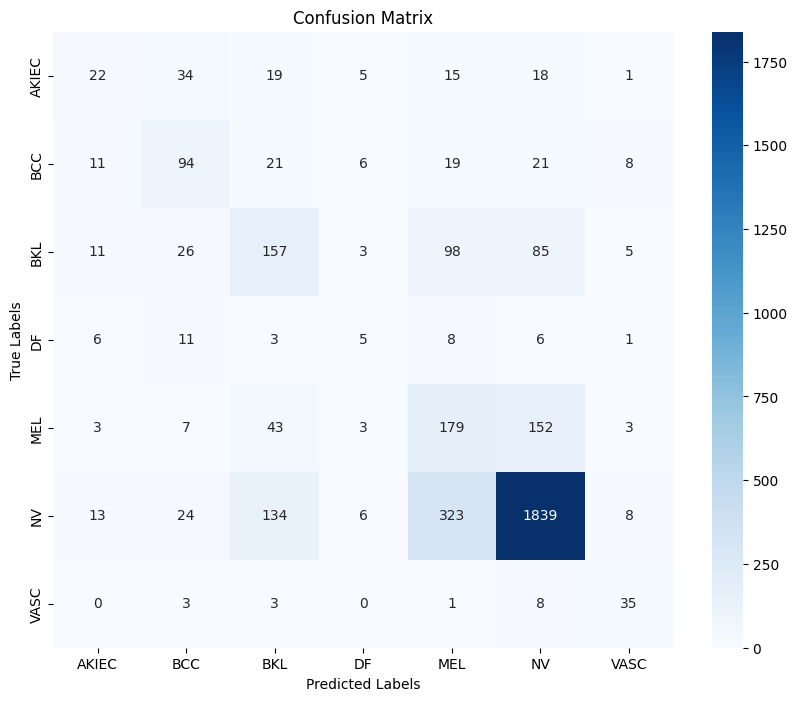


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.33      0.19      0.24       114
         BCC       0.47      0.52      0.50       180
         BKL       0.41      0.41      0.41       385
          DF       0.18      0.12      0.15        40
         MEL       0.28      0.46      0.35       390
          NV       0.86      0.78      0.82      2347
        VASC       0.57      0.70      0.63        50

    accuracy                           0.66      3506
   macro avg       0.44      0.46      0.44      3506
weighted avg       0.70      0.66      0.68      3506


Class: AKIEC
Precision: 0.3333
Recall: 0.1930
F1 Score: 0.2444

Class: BCC
Precision: 0.4724
Recall: 0.5222
F1 Score: 0.4960

Class: BKL
Precision: 0.4132
Recall: 0.4078
F1 Score: 0.4105

Class: DF
Precision: 0.1786
Recall: 0.1250
F1 Score: 0.1471

Class: MEL
Precision: 0.2784
Recall: 0.4590
F1 Score: 0.3466

Class: NV
Precision: 0.8638
Recall: 0.7836
F1 Score: 0.8217

Class:

In [21]:
metrics = evaluate(model, test_loader, device, num_classes, class_names)
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1'][i]:.4f}")

**Evaluate resnet50**

In [22]:
print(resnet50)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): block(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (identity_downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Confusion Matrix:
[[  38   11   25    4   15   21    0]
 [  27   59   23   15   10   44    2]
 [  17   19  195    6   31  117    0]
 [   2    3    6   13    4   12    0]
 [  10    6   65    4   85  218    2]
 [  12   20  158   11   60 2083    3]
 [   1    1    0    0    5    5   38]]


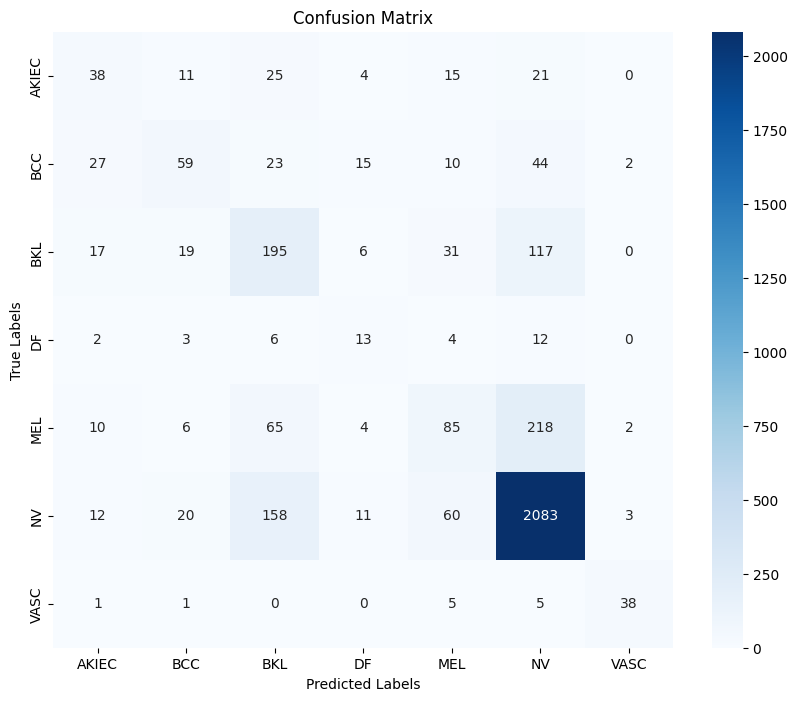


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.36      0.33      0.34       114
         BCC       0.50      0.33      0.39       180
         BKL       0.41      0.51      0.46       385
          DF       0.25      0.33      0.28        40
         MEL       0.40      0.22      0.28       390
          NV       0.83      0.89      0.86      2347
        VASC       0.84      0.76      0.80        50

    accuracy                           0.72      3506
   macro avg       0.51      0.48      0.49      3506
weighted avg       0.70      0.72      0.70      3506


Class: AKIEC
Precision: 0.3551
Recall: 0.3333
F1 Score: 0.3439

Class: BCC
Precision: 0.4958
Recall: 0.3278
F1 Score: 0.3946

Class: BKL
Precision: 0.4131
Recall: 0.5065
F1 Score: 0.4551

Class: DF
Precision: 0.2453
Recall: 0.3250
F1 Score: 0.2796

Class: MEL
Precision: 0.4048
Recall: 0.2179
F1 Score: 0.2833

Class: NV
Precision: 0.8332
Recall: 0.8875
F1 Score: 0.8595

Class:

In [23]:
metrics = evaluate(resnet50, test_loader, device, num_classes, class_names)
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1'][i]:.4f}")

In [24]:
print(Densenet)

DataParallel(
  (module): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Confusion Matrix:
[[  83    3   18    1    3    5    1]
 [  43   86   12    6    6   23    4]
 [  32   10  263    5   15   56    4]
 [   3    1    2   20    2   11    1]
 [  16    3  103    3  168   94    3]
 [  23   16  268    8   87 1941    4]
 [   0    1    0    0    1    2   46]]


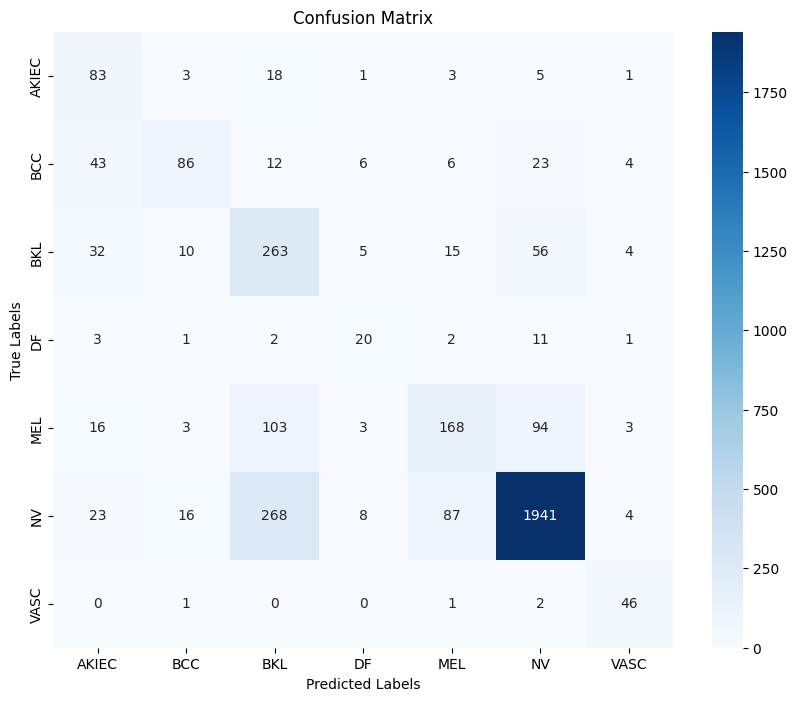


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.41      0.73      0.53       114
         BCC       0.72      0.48      0.57       180
         BKL       0.39      0.68      0.50       385
          DF       0.47      0.50      0.48        40
         MEL       0.60      0.43      0.50       390
          NV       0.91      0.83      0.87      2347
        VASC       0.73      0.92      0.81        50

    accuracy                           0.74      3506
   macro avg       0.60      0.65      0.61      3506
weighted avg       0.79      0.74      0.75      3506


Class: AKIEC
Precision: 0.4150
Recall: 0.7281
F1 Score: 0.5287

Class: BCC
Precision: 0.7167
Recall: 0.4778
F1 Score: 0.5733

Class: BKL
Precision: 0.3949
Recall: 0.6831
F1 Score: 0.5005

Class: DF
Precision: 0.4651
Recall: 0.5000
F1 Score: 0.4819

Class: MEL
Precision: 0.5957
Recall: 0.4308
F1 Score: 0.5000

Class: NV
Precision: 0.9104
Recall: 0.8270
F1 Score: 0.8667

Class:

In [25]:
metrics = evaluate(Densenet, test_loader, 'cuda', num_classes, class_names)
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1'][i]:.4f}")

### Thí nghiệm phụ
Loại bỏ skip connection của restnet50

In [26]:
class block_unSkip(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(block_unSkip, self).__init__()
        self.expansion = 4 #number of channels after a block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        x = self.relu(x)
        return x

In [27]:
class ResNetUnskip(nn.Module):
    def __init__(self, block_unSkip, image_channels = 3, num_classes = 7):
        super(ResNetUnskip, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3) #initial layer of resnet
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ResNetUnskip layers
        self.layer1 = self._make_layer(block_unSkip, 3, out_channels=64)
        self.layer2 = self._make_layer(block_unSkip, 4, out_channels=128)
        self.layer3 = self._make_layer(block_unSkip, 6, out_channels=256)
        self.layer4 = self._make_layer(block_unSkip, 3, out_channels=512) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)

        x = self.fc(x)

        return x


    def _make_layer(self, block_unSkip, num_residual_blocks, out_channels): # num_residual_blocks = number of times its gonna used the blocks
        layers = []
        layers.append(block_unSkip(self.in_channels, out_channels, stride=1))
        self.in_channels = out_channels * block_unSkip(self.in_channels, out_channels).expansion  # Update in_channels

        for i in range(num_residual_blocks - 1):
            layers.append(block_unSkip(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ResNetUnskip =  ResNetUnskip(block_unSkip)
ResNetUnskip = ResNetUnskip.to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.SGD(ResNetUnskip.parameters(), lr=0.0001, momentum=0.99, weight_decay=0.0001)
ResNetUnskip = nn.DataParallel(ResNetUnskip,device_ids =[0,1])
ResNetUnskip, historry = train(ResNetUnskip, train_loader, criterion, optimizer, num_epochs = 20, device=device,path="/kaggle/working/ResNetUnskip.pth")

Epoch 1/20


Epoch 1:   0%|          | 0/204 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1: 100%|██████████| 204/204 [05:40<00:00,  1.67s/batch, accuracy=34, loss=2.05]


Epoch 2/20


Epoch 2: 100%|██████████| 204/204 [05:36<00:00,  1.65s/batch, accuracy=26.6, loss=1.39]


Epoch 3/20


Epoch 3: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=38.9, loss=1.39]


Epoch 4/20


Epoch 4: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=44.3, loss=1.71]


Epoch 5/20


Epoch 5: 100%|██████████| 204/204 [05:36<00:00,  1.65s/batch, accuracy=45.8, loss=1.65]


Epoch 6/20


Epoch 6: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=45.6, loss=0.914]


Epoch 7/20


Epoch 7: 100%|██████████| 204/204 [05:35<00:00,  1.64s/batch, accuracy=45.1, loss=1.73]


Epoch 8/20


Epoch 8: 100%|██████████| 204/204 [05:35<00:00,  1.64s/batch, accuracy=47.7, loss=1.16]


Epoch 9/20


Epoch 9: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=48.3, loss=1.68]


Epoch 10/20


Epoch 10: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=47.2, loss=1.27]


Epoch 11/20


Epoch 11: 100%|██████████| 204/204 [05:35<00:00,  1.64s/batch, accuracy=46.9, loss=1.75]


Epoch 12/20


Epoch 12: 100%|██████████| 204/204 [05:36<00:00,  1.65s/batch, accuracy=47.8, loss=1.87]


Epoch 13/20


Epoch 13: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=51.1, loss=1.39]


Epoch 14/20


Epoch 14: 100%|██████████| 204/204 [05:36<00:00,  1.65s/batch, accuracy=50.8, loss=1.61]


Epoch 15/20


Epoch 15: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=50.1, loss=1.46]


Epoch 16/20


Epoch 16: 100%|██████████| 204/204 [05:35<00:00,  1.64s/batch, accuracy=52.9, loss=2.14]


Epoch 17/20


Epoch 17: 100%|██████████| 204/204 [05:35<00:00,  1.64s/batch, accuracy=51.8, loss=1.39]


Epoch 18/20


Epoch 18: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=54.8, loss=1.94]


Epoch 19/20


Epoch 19: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=55, loss=1.26]


Epoch 20/20


Epoch 20: 100%|██████████| 204/204 [05:35<00:00,  1.65s/batch, accuracy=53.2, loss=1.5]
/tmp/ipykernel_23/483945860.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode

Confusion Matrix:
[[  44   23   15   19    5    3    5]
 [  23   81   24   26    4    0   22]
 [  21   42  217   44   25   15   21]
 [   3   11    7   13    2    1    3]
 [  23   17  138    5  138   47   22]
 [  28  130  524   49  246 1292   78]
 [   0    0    1    0    0    2   47]]


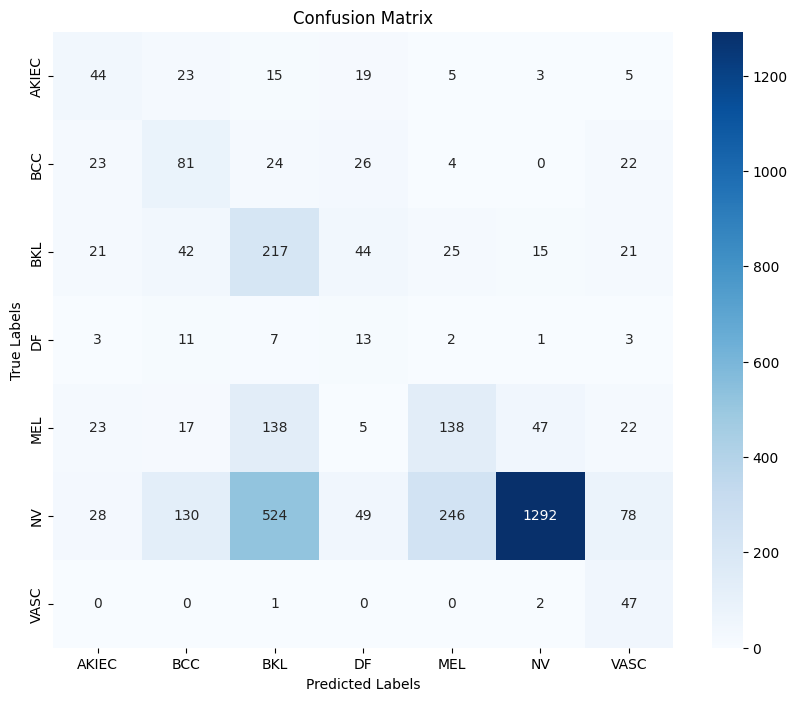


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.31      0.39      0.34       114
         BCC       0.27      0.45      0.33       180
         BKL       0.23      0.56      0.33       385
          DF       0.08      0.33      0.13        40
         MEL       0.33      0.35      0.34       390
          NV       0.95      0.55      0.70      2347
        VASC       0.24      0.94      0.38        50

    accuracy                           0.52      3506
   macro avg       0.34      0.51      0.37      3506
weighted avg       0.73      0.52      0.58      3506


Class: AKIEC
Precision: 0.3099
Recall: 0.3860
F1 Score: 0.3438

Class: BCC
Precision: 0.2664
Recall: 0.4500
F1 Score: 0.3347

Class: BKL
Precision: 0.2343
Recall: 0.5636
F1 Score: 0.3310

Class: DF
Precision: 0.0833
Recall: 0.3250
F1 Score: 0.1327

Class: MEL
Precision: 0.3286
Recall: 0.3538
F1 Score: 0.3407

Class: NV
Precision: 0.9500
Recall: 0.5505
F1 Score: 0.6971

Class:

In [29]:
metrics = evaluate(ResNetUnskip, test_loader, 'cuda', num_classes, class_names)
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1'][i]:.4f}")